# Do Parents Talk to Boys and Girls Differently During Play?


Recently, there has been increasing focus on gender differences and parenting in research and the popular press. This is especially prominent in light of gender disparities in STEM education. One reason for this disparity might stem from how parents speak to their young children during play (e.g., Crowley, Callanan, Tenenbaum, & Allen, 2001; Tenenbaum & Leaper, 2003). 

## The goal of this project was to investigate whether parents would speak to their children differently depending on gender in a neutral play setting in our laboratory.

Data for this project came from a study investigating word learning skills in toddlers in my [lab](https://labs.la.utexas.edu/little-learners-lab/) at UT Austin. With much help from a talented research assistant, Katherine Soon, we transcribed a random sample of parent-child play sessions. In this project, I examine the types of words parents use with their toddlers during a brief play session with this [toy](http://www.melissaanddoug.com/bug-catching-magnetic-puzzle-game/3779.html?utm_source=google&utm_medium=shopping&utm_campaign=PLA_B_Active_Play_Desk&utm_term=Active_Play_Outdoor&utm_content=a6&product_id=ae0f052115fca3351fc50a1fa59a6392&gclid=EAIaIQobChMIxZTwxMqf2QIVW57ACh1mvgIKEAQYAyABEgLZD_D_BwE) in the lab. 

In [6]:
#Import libraries
import os
import nltk
import re
from os import path
from textblob import TextBlob
from wordcloud import WordCloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

from collections import Counter

from yellowbrick.style import set_palette
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

First, I wanted to see what words parents were using with boys and girls. An easy way for me to visualize the words and frequency of usage was to create word clouds- a perennial favorite. 

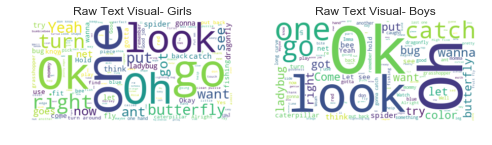

In [7]:
#set directory
d = path.dirname('/Users/jessieraye/Desktop/Parent Transcriptions/')
# Read the raw text file
femaletext = open(path.join(d, 'allfemales.txt')).read()
maletext = open(path.join(d, 'allmales.txt')).read()

# Generate a word cloud image
wordcloudfemaleraw = WordCloud(background_color='white').generate(femaletext)
wordcloudmaleraw = WordCloud(background_color='white').generate(maletext)

# Display the generated image with matplotlib:
wordcloud_cleanF = WordCloud(background_color='white').generate(femaletext)
plt.subplot(1, 2, 1)
plt.imshow(wordcloudfemaleraw, interpolation='bilinear')
plt.axis("off")
plt.title("Raw Text Visual- Girls")

plt.subplot(1, 2, 2)
wordcloud_cleanM = WordCloud(background_color='white').generate(maletext)
plt.imshow(wordcloudmaleraw, interpolation='bilinear')
plt.axis("off")
plt.title("Raw Text Visual- Boys")
plt.show()


Next, I will read in a dataframe where each row represents a participant. To create this dataframe, I read in each text file and appended it to a dataframe. Note that the participant ID has been removed for privacy. 

In [8]:
dffemale = pd.read_table('/Users/jessieraye/Desktop/Parent Transcriptions/females.csv',
                       sep = ',' )
dfmale = pd.read_table('/Users/jessieraye/Desktop/Parent Transcriptions/males.csv',
                       sep = ',' )
alldf = pd.concat([dffemale, dfmale])
#for privacy reasons, remove subject ID 
alldf = alldf.drop('idcol', axis=1)
alldf = alldf.drop('Unnamed: 0', axis=1)
alldf.head()## take a peak

,gender,transcript
0,f,"Ok. Pick up the, pick up the butterfly. Here, ..."
1,f,"Where this one go? Look at you, you�_re right...."
2,f,"What is that? Ooh, that looks like a spider. W..."
3,f,"What is this? Yeah. Angel, what is this? Not n..."
4,f,Do you want to do the red net or the blue net?...


The text looks messy. We need to remove puncuation, unrecognized characters and common "stop" words. First, let's remove punctuation and symbols. 

In [9]:
## function to clean up text and remove any special characters
def clean_text(content):
    '''
    clean the text by removing 
    special characters w. regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", content).split())

In [10]:
alldf['cleantext'] = [ clean_text(content) for content in alldf['transcript'] ]

Next, let's remove stop words. I also added some words I noticed from perusing the dataframe that were very common, but not helpful in determining meaningful differences between genders. 

In [11]:
cachedStopWords = set(stopwords.words("english"))
#add custom words
cachedStopWords.update(('oh', 'what','ok','okay', 'one', 'ooh', 'wanna'))
cachedStopWords.remove('no');

## add clean text to DFs
alldf['cleantext'] = alldf['cleantext'].str.lower()
alldf['text_without_stopwords'] = alldf['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in cachedStopWords]))
#print(dffemale['text_without_stopwords'])

Create tokens.

In [12]:
## create clean text object for later analyses
cleanfemale = clean_text(femaletext)
cleanfemale = cleanfemale.lower()  # lower(), since stopwords are all lower case
tokenizer = RegexpTokenizer(r'\w+')
tokensF = tokenizer.tokenize(cleanfemale)
tokensF = [token for token in tokensF if token not in cachedStopWords]  # filter stopwords
fdistF = FreqDist(tokensF)
tokensF[:10]

['looks',
 'like',
 'spider',
 'spider',
 'spider',
 'dragonfly',
 'dragonfly',
 'baby',
 'dragonfly',
 'goes']

In [13]:
## create clean text object for later analyses
cleanmale = clean_text(maletext)
cleanmale = cleanmale.lower()  # lower(), since stopwords are all lower case
tokensM = tokenizer.tokenize(cleanmale)
tokensM = [token for token in tokensM if token not in cachedStopWords]  # filter stopwords
fdistM = FreqDist(tokensM)
tokensM[:10]

['ladybug',
 'butterfly',
 'bee',
 'another',
 'butterfly',
 'grasshopper',
 'spider',
 'bee',
 'looks',
 'like']

In a first step towards clarifying whether or not gender differences exist, I decided to look at the frequency of words used in each gender. I used a handy function 'word_vectorizer.fit_transform' 

In [14]:
word_vectorizer = CountVectorizer(analyzer='word')
##females
word_matF = word_vectorizer.fit_transform(alldf['text_without_stopwords'][alldf['gender'] == 'f'])
frequenciesF = sum(word_matF).toarray()[0]
freqFemale = pd.DataFrame(frequenciesF, index=word_vectorizer.get_feature_names(), columns=['frequency'])

#males
word_matM = word_vectorizer.fit_transform(alldf['text_without_stopwords'][alldf['gender'] == 'm'])
frequenciesM = sum(word_matM).toarray()[0]
freqMale = pd.DataFrame(frequenciesM, index=word_vectorizer.get_feature_names(), columns=['frequency'])

Word frequency dataframe for later analyses.

In [15]:
freqwordsF = freqFemale.sort_values('frequency', ascending=False)
freqwordsM = freqMale.sort_values('frequency', ascending=False)

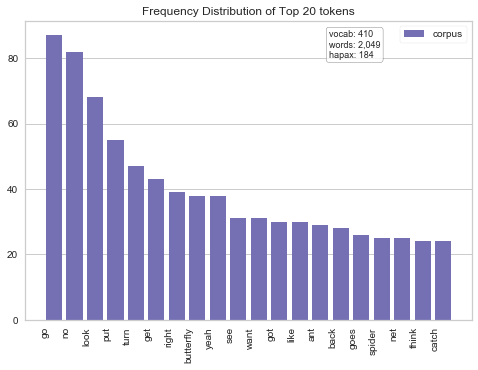

In [16]:
set_palette('dark')
vectorizer = CountVectorizer()
word_matF       = vectorizer.fit_transform(alldf['text_without_stopwords'][alldf['gender'] == 'f'])
features   = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient = 'v', n=20)
visualizer.fit(word_matF)
visualizer.poof()

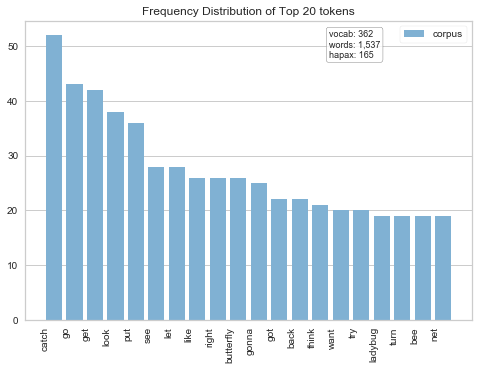

In [17]:
set_palette('muted')
vectorizer = CountVectorizer()
word_matM       = vectorizer.fit_transform(alldf['text_without_stopwords'][alldf['gender'] == 'm'])
features   = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient = 'v', n=20)
visualizer.fit(word_matM)
visualizer.poof()

Upon initial inspection, it looks like the frequency of word usage is fairly equivalent across gender- which is good news!

Another interesting analyis might be to investigate how often parents use certain TYPES of words across gender. To do so, I created four text corpora: positive, negative, science-related, and animal words. 

I used the positive and negative text corpora from [here](http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html). 

I created the science-related words by using a list of terms from this [site](http://www.descriptionkey.org/vocab/stem.html#pre-k), and then adding additional terms I frequently observed while transcribing. For example, I included the words "predict," "try" and "guess," which are heavily tied to STEM and the scientific method. 

I then created the animal corpus by using part of the [MCDI](https://mb-cdi.stanford.edu/) and adding specific animals from the game the parent-child dyads were playing with during the task (e.g., "caterpillar" and "ant"). 

Next, I counted how many times a word in each category appeared in both sets of transcripts. 

In [18]:
#create male and female tokens 
fjoinedtogether = " ".join(tokensF)
Mjoinedtogether = " ".join(tokensM)

Read in text corpora.

In [19]:
def readwords( filename ):
    f = open(filename)
    words = [ line.rstrip() for line in f.readlines()]
    return words

positive = readwords('positivetext.txt')
negative = readwords('negativewords.txt')
science = readwords('science-words.txt')
animals = readwords('animals.txt')

Set counter for each word type to zero.

In [20]:
countF = Counter(fjoinedtogether.split())
countM = Counter(Mjoinedtogether.split())

posf = 0
negf = 0
sciencef = 0
animalsf = 0
posm = 0
negm = 0
sciencem = 0
animalsm = 0

Iterate through each genders' tokens and count the number of times a word from a corpus appeared. 

In [21]:
for key, val in countF.iteritems():
    key = key.rstrip('.,?!\n') # removing possible punctuation signs
    if key in positive:
        posf += val
    if key in negative:
        negf += val    
    if key in science:
        sciencef += val
    if key in animals:
        animalsf += val

for key, val in countM.iteritems():
    if key in positive:
        posm += val
    if key in negative:
        negm += val    
    if key in science:
        sciencem += val
    if key in animals:
        animalsm += val 

Get totals to calculate percentages. 

In [22]:
countf = len(re.findall(r'\w+', fjoinedtogether))
otherf = countf - (posf+negf+ sciencef+ animalsf)
countm = len(re.findall(r'\w+', Mjoinedtogether))
otherm = countm - (posm+negm+ sciencem+ animalsm)

Create dataframe with number of words and percentages per word category split by gender

In [23]:
wordcats = [ ('Word Category', ['Positive', 'Negative', 'Science', 'Animals', 'Other']),
          ('Girls', [posf, negf, sciencef, animalsf,otherf]),
           ('Boys', [posm, negm, sciencem, animalsm,otherm])]
wordcatsdf = pd.DataFrame.from_items(wordcats)
wordcatsdf['Girls (%)'] = (wordcatsdf['Girls']/countf)*100
wordcatsdf['Boys (%)'] = (wordcatsdf['Boys']/countm)*100
desired_decimals = 2    
wordcatsdf['Girls (%)'] = wordcatsdf['Girls (%)'].apply(lambda x: round(x,desired_decimals))
wordcatsdf['Boys (%)'] = wordcatsdf['Boys (%)'].apply(lambda x: round(x,desired_decimals))
wordcatsdf

,Word Category,Girls,Boys,Girls (%),Boys (%)
0,Positive,154,120,7.71,7.55
1,Negative,42,49,2.10,3.08
2,Science,73,61,3.65,3.84
3,Animals,218,162,10.91,10.20
4,Other,1511,1197,75.63,75.33


Let's plot this with a nice bar plot to compare the genders.

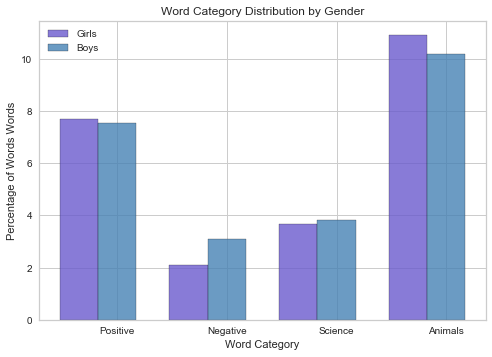

In [24]:
#remove last row of DF since 'other' category is not incredibly helpful
wordcatsdfplt = wordcatsdf[:-1]

# create plot
fig, ax = plt.subplots()
index = np.arange(len(wordcatsdfplt['Word Category']))
bar_width = 0.35
opacity = 0.8
 
girls1 = plt.bar(index, wordcatsdfplt['Girls (%)'], bar_width,
                 alpha=opacity,
                 color='slateblue',
                 label='Girls',
                 edgecolor='black')
 
boys2 = plt.bar(index + bar_width, wordcatsdfplt['Boys (%)'], bar_width,
                 alpha=opacity,
                 color='steelblue',
                 label='Boys',
                 edgecolor='black')
 
plt.xlabel('Word Category')
plt.ylabel('Percentage of Words Words')
plt.title('Word Category Distribution by Gender')
plt.xticks(index + bar_width, (wordcatsdfplt['Word Category']))
plt.legend()
 
plt.show()

## Results

According to our data, we did not observe any gender differences between the types of words (e.g., negative or amount of STEM-related) that parents used with 2-year olds. This is good news in light of the recent evidence that there are vast differences in how parents approach play and speak with their children depending on their gender.  However, this project is limited in several aspects. First, our sample size was small. I only used a sub sample from the data avaiable in my lab. Second, I only explored at tokens. I did not examine bigrams, or other more advanced NLP techniques here. Third and finally, the task used in this parent-child interaction was not necessarily designed to promote any type of STEM education or related prompting from parents. Since the task was play-based and neutral (no direct instructions were given), this might explain the similar results between the genders. 

Let's end with cleaned up versions of word clouds for each gender. 

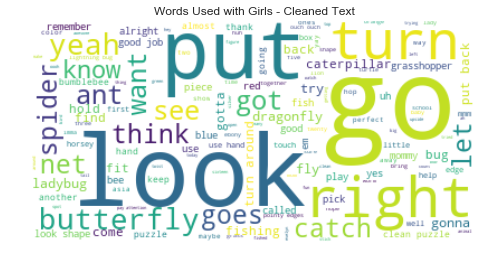

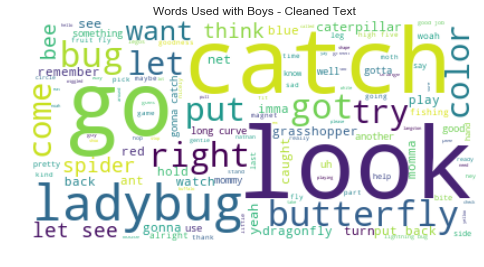

In [25]:
wordcloud_cleanF = WordCloud(background_color='white').generate(fjoinedtogether)
plt.imshow(wordcloud_cleanF, interpolation='bilinear')
plt.axis("off")
plt.title("Words Used with Girls - Cleaned Text")
plt.show()

wordcloud_cleanM = WordCloud(background_color='white').generate(Mjoinedtogether)
plt.imshow(wordcloud_cleanM, interpolation='bilinear')
plt.axis("off")
plt.title("Words Used with Boys - Cleaned Text")
plt.show()

### References:
1.  Crowley, K., Callanan, M. A., Tenenbaum, H. R., & Allen, E. (2001). Parents explain more often to boys than to girls during shared scientific thinking. Psychological Science, 12(3), 258-261.
2.  Tenenbaum, H. R., & Leaper, C. (2003). Parent-child conversations about science: The socialization of gender inequities. Developmental psychology, 39(1), 34.	
3.  Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." Proceedings of the ACM SIGKDD International Conference on Knowledge. Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA.
4. Fenson, L., Marchman, V. A., Thal, D. J., Dale, P. S., Reznick, J. S., and Bates, E. (2007). MacArthur-Bates Communicative Development Inventories: User's Guide and Technical Manual - Second Edition. Baltimore: Brookes Publishing.
5. http://www.descriptionkey.org/vocab/stem.html#pre-k
6. [The Little Learners Lab](https://labs.la.utexas.edu/little-learners-lab/) at UT Austin